In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('D:\\main\\1_projects\\DATA SCIENCE\\SF_machine_learning\\repeating_practice\\data\\fish.zip')
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
data.shape

(159, 7)

Выведем информацию о пропусках и о типах данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [5]:
data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [6]:
data.describe(include='object')

,Species
count,159
unique,7
top,Perch
freq,56


Проведем небольшое исследование зависимости целевого признака weight от числовых признаков.

In [7]:
types = data.dtypes
num_features = list(types[types != 'object'].index)
num_features

['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']

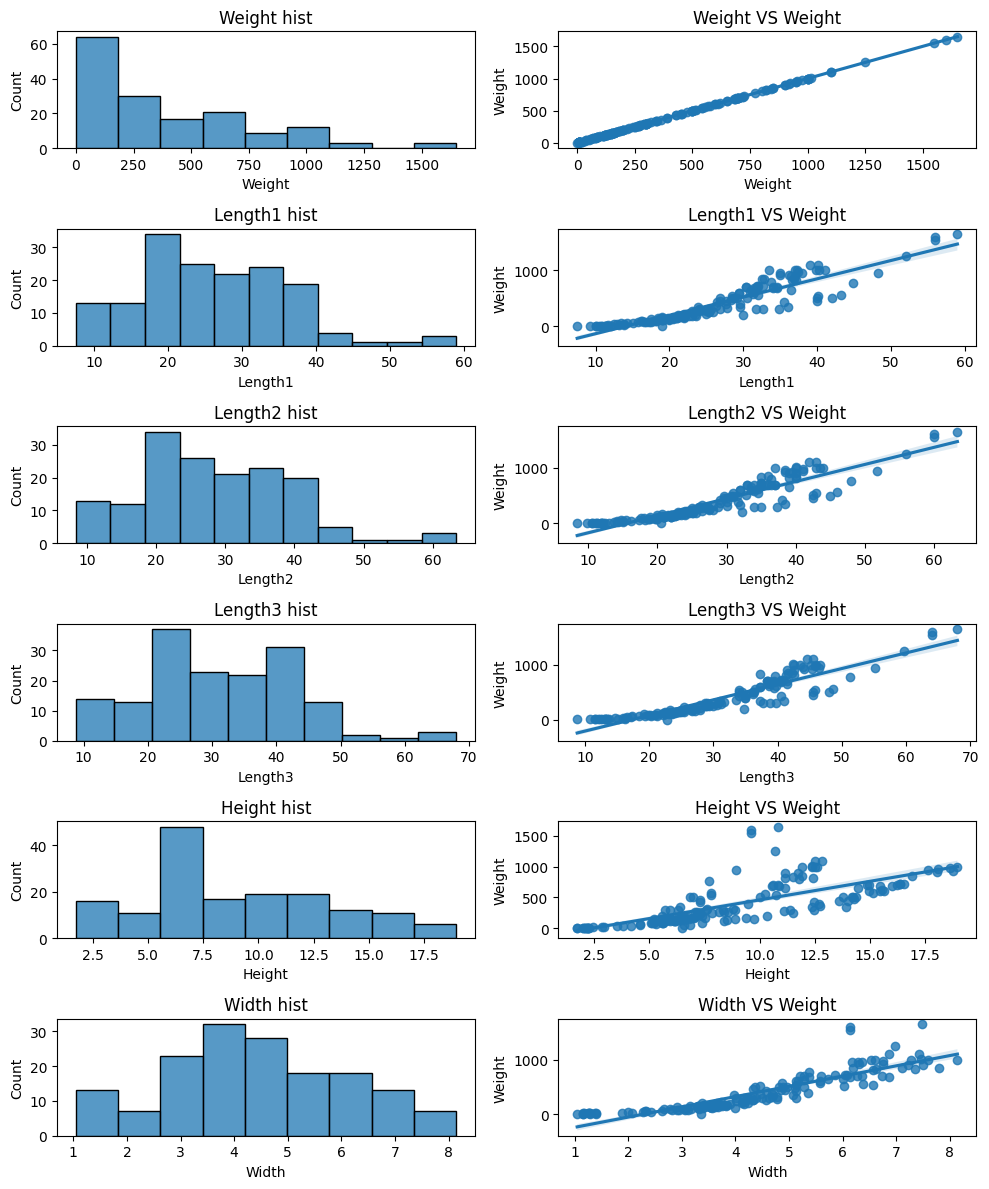

In [8]:
n = len(num_features) # определяем количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(10, 2*n))
# цикл для всех признаков из списка
for i, feature in enumerate(num_features):
    # строим гистограмму распределения и признака
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title(f'{feature} hist')
    # строим диаграмму рассеяния и линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='Weight', ax=axes[i][1])
    regplot.set_title(f'{feature} VS Weight')
plt.tight_layout() # выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (price)

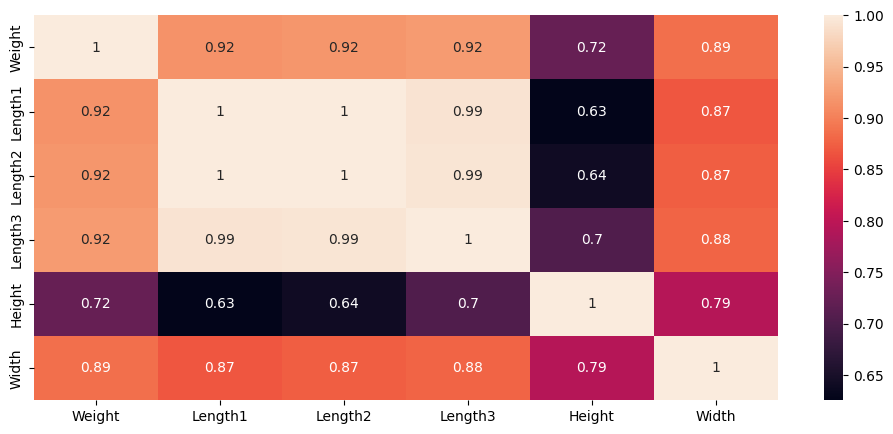

In [9]:
fig = plt.figure(figsize=(12, 5))
sns.heatmap(data[num_features].corr(), annot=True);

По большинству признаков наблюдается мультиколлинеарность.
В любом случае пробуем построить модель.

функция для оценки метрик модели

In [10]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    """Выводит информацию о метриках

    Args:
        y_train (_type_): Series
        y_train_predict (_type_): Series
        y_test (_type_): Series
        y_test_predict (_type_): Series
    """
    print(f'Train R^2: {round(metrics.r2_score(y_train, y_train_predict), 3)}')
    print(f'Train MAE: {round(metrics.mean_absolute_error(y_train, y_train_predict), 3)}')
    print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train, y_train_predict), 3)}')
    print()
    
    print(f'Test R^2: {round(metrics.r2_score(y_test, y_test_predict), 3)}')
    print(f'Test MAE: {round(metrics.mean_absolute_error(y_test, y_test_predict), 3)}')
    print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test, y_test_predict), 3)}')

### Построение модели

Убираем значения строки с признаком weight = 0

In [11]:
temp_data = data.copy()
temp_data = temp_data[temp_data['Weight']>0]
temp_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


проведем кодирование категориальных признаков

In [13]:
# для информации смотрим, какое количество экземпляров датасета относится к тому или иному виду рыб
data['Species'].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

проводим кодирование категориального признака

In [14]:
dummie_data = pd.get_dummies(temp_data)
dummie_data.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


In [15]:
# Разделяем датасет на матрицу признаков и вектор правильных ответов
X = dummie_data.drop(columns='Weight')
y = dummie_data['Weight']

# разделяем датасет на тренировочную и тестовую выборки. Метод train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и вектор правильных овтетов
    test_size=0.2,
    random_state=42
)

# выводим размеры полученых выборок
print(f'Train shape: - X:{X_train.shape}: y - {y_train.shape}')
print(f'Test shape: - X:{X_test.shape}: y - {y_test.shape}')

Train shape: - X:(126, 12): y - (126,)
Test shape: - X:(32, 12): y - (32,)


Построим на предобработанных данных модель линейной регрессии

In [16]:
# создаем логарифмированный целевой признак цены
y_train_log = np.log(y_train)
# инициализируем объект класса
lr = linear_model.LinearRegression()
# обучаем модель предсказывать логарифм целевого признака
lr.fit(X_train, y_train_log)
# Делаем предсказания. От результата беерм экспоненту, т.к. обучали на логарифме
y_train_pred = np.exp(lr.predict(X_train))
y_test_pred = np.exp(lr.predict(X_test))

# выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.823
Train MAE: 57.909
Train MAPE: 0.164

Test R^2: 0.832
Test MAE: 77.175
Test MAPE: 0.153


Попробуем добавить в данные полиномиальные признаки и построить модель полиномиальной регрессии. Предварительно нормализуем данные:

In [17]:
# Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
# вычисляем параметры для нормализации
scaler.fit(X_train)
# производим преобразования для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# создаем объект для генерации полиномиальных признаков второй степени
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# вычисляем параметры генерации полиномиальных признаков
poly.fit(X_train_scaled)
# производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (126, 90)
Test shape: (32, 90)


In [18]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train_log)
y_train_pred = np.exp(lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(lr_poly.predict(X_test_scaled_poly))

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.992
Train MAE: 17.351
Train MAPE: 0.052

Test R^2: 0.866
Test MAE: 73.574
Test MAPE: 0.148


Стоим модель с учетом R-2 регуляризации

In [19]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
# обучаем модель на логарифме целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
# делаем предсказание для каждой выборки
y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))

# выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.938
Train MAE: 45.724
Train MAPE: 0.157

Test R^2: 0.918
Test MAE: 48.785
Test MAPE: 0.137


Выбираем наилучшую alpha

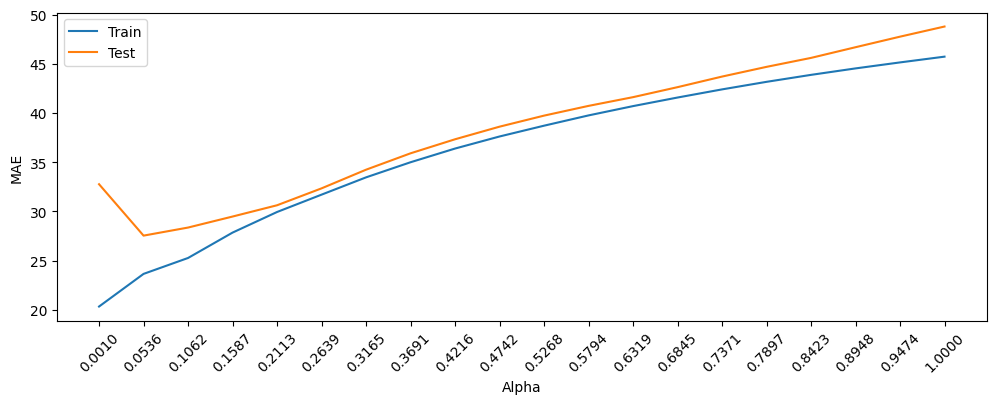

In [20]:
#Создаем список из 20 возможных значений от 0.001 до 0.1
alpha_list = np.linspace(0.001, 1, 20)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))
    
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

In [21]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge(alpha=0.20)
# обучаем модель на логарифме целевого признака
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
# делаем предсказание для каждой выборки
y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))

# выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.979
Train MAE: 29.52
Train MAPE: 0.096

Test R^2: 0.977
Test MAE: 30.375
Test MAPE: 0.093
